In [238]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')
from film import TwoMaterialFilm, FreeFormFilm
from spectrum import Spectrum
from design import BaseDesign, DesignForSpecSimple
import os
import torch
from utils.loss import calculate_RMS_f_spec
from analyze_utils.structure import plot_layer_thickness
import dill
import tqdm
from optimizer.adam import AdamThicknessOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def make_bandpass_filter_design():
    inc_ang = 0.
    wls = np.linspace(440, 560, 500) # when wls = 50, ~100 min
    R = np.ones_like(wls)
    R[(480 < wls) & (wls < 520)] = 0

    
    R = R[(wls < 475) | ((wls > 480) & (wls < 520)) | (wls > 530)]
    wls = wls[(wls < 475) | ((wls > 480) & (wls < 520)) | (wls > 530)]
    return [Spectrum(inc_ang, wls, R)]
    
    
def make_edgefilter_design(init_film: TwoMaterialFilm):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    # R = np.ones(wls.shape[0] , dtype='float')
    R = np.zeros(wls.shape[0] , dtype='float')
    R[wls.shape[0] // 2:] = 1.
    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = DesignForSpecSimple(target_spec, init_film)
    return design


from analyze_utils.make_design import get_minus_filter_spec

def make_minus_filter_design(init_film, height):
    wls = np.linspace(400, 700, 500)
    spec = get_minus_filter_spec(wls, h=height) 
    return DesignForSpecSimple(spec, init_film, )
    
def make_three_line_filter_design(init_film: TwoMaterialFilm, density_mul=2):
    inc_ang = 0.
    def make_r_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, density_mul * int(wl_2 - wl_1))
        R = np.ones(wls.shape[0] , dtype='float')
        return R
    def make_t_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, density_mul * int(wl_2 - wl_1))
        R = np.zeros(wls.shape[0] , dtype='float')
        return R
    make_wl = lambda x1, x2: np.linspace(x1, x2, density_mul * int(x2 - x1), dtype='float')
    
    wls, R = np.array([]), np.array([])
    
    wls = np.append(wls, make_wl(400, 440))
    R = np.append(R, make_r_spec(400, 440))

    wls = np.append(wls, make_wl(445, 455))
    R = np.append(R, make_t_spec(445, 455))

    wls = np.append(wls, make_wl(460, 500))
    R = np.append(R, make_r_spec(460, 500))
    
    wls = np.append(wls, make_wl(505, 515))
    R = np.append(R, make_t_spec(505, 515))

    wls = np.append(wls, make_wl(520, 630))
    R = np.append(R, make_r_spec(520, 630))
    
    wls = np.append(wls, make_wl(635, 645))
    R = np.append(R, make_t_spec(635, 645))
    
    wls = np.append(wls, make_wl(650, 700))
    R = np.append(R, make_r_spec(650, 700))

    target_spec = [Spectrum(inc_ang, wls, R)]
    
    design = DesignForSpecSimple(target_spec, init_film)
    return design


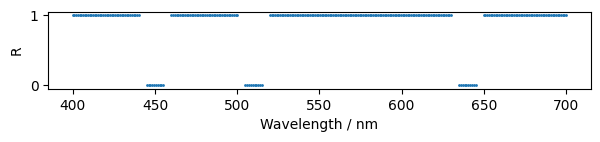

In [19]:

design = make_three_line_filter_design(TwoMaterialFilm(1, 2, 1, np.random.rand(10)), density_mul=1)
r = design.target_specs[0].get_R()
wls = design.target_specs[0].WLS

fig, ax = plt.subplots(1, 1)
ax.scatter(wls, r, s=1, marker='o')
ax.set_ylabel('R')
ax.set_xlabel('Wavelength / nm')
fig.set_size_inches(7, 1)
fig.savefig('./images/threeline_filter_target.pdf', bbox_inches='tight')


In [236]:
# bandpass filter design

def exp():
    specs = make_bandpass_filter_design()
    d_init = np.random.rand(200) * 50
    film = TwoMaterialFilm(1.45, 2.35, 1.52, d_init)
    # film.remove_negative_thickness_layer()
    adam = AdamThicknessOptimizer(
        film, 
        specs, 
        max_steps=2000, 
        remove_nonpos_during_optm=True, 
        show=True, 
        show_condition=lambda i: i % 50 == 0, 
        alpha=3, 
        record=lambda i: i == 1999
    )
    adam.optimize()
    return adam.records[-1][0], specs

def plot(film, specs, fname):
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': (4, 1), 'hspace': 0.5})
    # fig.set_size_inches(5, 10)

    film_spec = film.get_spec(inc_ang=0, wls=np.linspace(440, 560, 500))
    ax = axes[0]
    ax.plot(film_spec.WLS, film_spec.get_R(), label='Design', zorder=1, color='C3')
    ax.scatter(specs[0].WLS, specs[0].get_R(), label='Target', marker='x', s=10, zorder=2, alpha=0.15)

    ax.set_title(f'MSE: {calculate_RMS_f_spec(film, specs): .5f}, final layer number: {film.get_layer_number()}')
    # print(film.get_layer_number())
    # film.remove_negative_thickness_layer(zero=10)
    # print(film.get_layer_number())
    # ax.plot(film.get_spec().WLS, film.get_spec().get_R(), label='After removal')

    ax.legend()
    ax.set_xlabel('Wavelength / nm')
    ax.set_ylabel('R')
    fig.set_size_inches(5, 3)

    plot_layer_thickness(film, ax=axes[1])
    axes[1].set_ylabel('n')
    axes[1].set_xlabel('Thickness / nm')

    fig.set_size_inches(5, 4)
    fig.savefig(f'./images/filter/{fname}.pdf', bbox_inches='tight')

for i in range(5):
    np.random.seed(i)

    film, specs = exp()
    plot(film, specs, f'bandpass_start_200_rep_{i}')

In [205]:
print(film.get_layer_number())
film.get_d()
print(adam._validate_loss())
# 98 layers, 0.002591527609984841
# 86 layers, 0.0020527073532588896
# 84 layers, 0.0018274280515845646

# 48 layers, 0.005934011623621828

60
0.007852541158112458


In [ ]:
# thermo mirror design

def get_hot_mirror_spec():
    inc_ang = 0

    wls_pass = np.linspace(400, 700, 300)
    wls_block = np.linspace(720, 1200, 300)

    R_1 = np.zeros_like(wls_pass)
    R_2 = np.ones_like(wls_block)

    wls = np.append(wls_pass, wls_block)
    R = np.append(R_1, R_2)
    return [Spectrum(inc_ang, wls, R)]

target = get_hot_mirror_spec()
np.random.seed(0)
d_init = np.random.rand(100) * 100
film = TwoMaterialFilm(1.45, 2.35, 1.52, d_init)
# film.remove_negative_thickness_layer()
adam = AdamThicknessOptimizer(
    film, 
    target, 
    max_steps=2000, 
    remove_nonpos_during_optm=False, 
    show=True, 
    show_condition=lambda i: i % 50 == 0, 
    alpha=3, 
    record=lambda i: i == 1999
)
adam.optimize()



film has no spec. use 1000 nm


/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


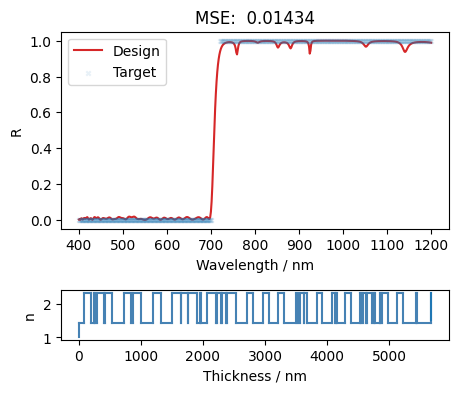

In [267]:

def plot(film, specs, fname):
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': (4, 1), 'hspace': 0.5})
    # fig.set_size_inches(5, 10)

    film_spec = film.get_spec(inc_ang=0, wls=np.linspace(400, 1200, 500))
    ax = axes[0]
    ax.plot(film_spec.WLS, film_spec.get_R(), label='Design', zorder=1, color='C3')
    ax.scatter(specs[0].WLS, specs[0].get_R(), label='Target', marker='x', s=10, zorder=2, alpha=0.1)

    ax.set_title(f'MSE: {calculate_RMS_f_spec(film, specs): .5f}') #, final layer number: {film.get_layer_number()}')
    # print(film.get_layer_number())
    # film.remove_negative_thickness_layer(zero=10)
    # print(film.get_layer_number())
    # ax.plot(film.get_spec().WLS, film.get_spec().get_R(), label='After removal')

    ax.legend()
    ax.set_xlabel('Wavelength / nm')
    ax.set_ylabel('R')
    fig.set_size_inches(5, 3)

    plot_layer_thickness(film, ax=axes[1])
    axes[1].set_ylabel('n')
    axes[1].set_xlabel('Thickness / nm')

    fig.set_size_inches(5, 4)
    fig.savefig(f'./images/hot_mirror/{fname}.pdf', bbox_inches='tight')

film.remove_negative_thickness_layer()
plot(film, target, fname='hot_start_200layer_100nm_narrow_jump')

In [ ]:
def make_three_line_filter_spec(density_mul=2):
    inc_ang = 0.
    def make_r_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, density_mul * int(wl_2 - wl_1))
        R = np.ones(wls.shape[0], dtype='float')
        return R
    def make_t_spec(wl_1, wl_2):
        wls = np.linspace(wl_1, wl_2, density_mul * int(wl_2 - wl_1))
        R = np.zeros(wls.shape[0], dtype='float')
        return R
    make_wl = lambda x1, x2: np.linspace(x1, x2, density_mul * int(x2 - x1), dtype='float')
    
    wls, R = np.array([]), np.array([])
    
    wls = np.append(wls, make_wl(400, 440))
    R = np.append(R, make_r_spec(400, 440))

    wls = np.append(wls, make_wl(445, 455))
    R = np.append(R, make_t_spec(445, 455))

    wls = np.append(wls, make_wl(460, 500))
    R = np.append(R, make_r_spec(460, 500))
    
    wls = np.append(wls, make_wl(505, 515))
    R = np.append(R, make_t_spec(505, 515))

    wls = np.append(wls, make_wl(520, 630))
    R = np.append(R, make_r_spec(520, 630))
    
    wls = np.append(wls, make_wl(635, 645))
    R = np.append(R, make_t_spec(635, 645))
    
    wls = np.append(wls, make_wl(650, 700))
    R = np.append(R, make_r_spec(650, 700))

    target_spec = [Spectrum(inc_ang, wls, R)]
    return target_spec

target = make_three_line_filter_spec()
np.random.seed(2)
d_init = np.random.rand(100) * 50
film = TwoMaterialFilm(1.45, 2.35, 1.52, d_init)
# film.remove_negative_thickness_layer()
adam = AdamThicknessOptimizer(
    film, 
    target, 
    max_steps=4000, 
    remove_nonpos_during_optm=False, 
    show=True, 
    show_condition=lambda i: i % 50 == 0, 
    alpha=1, 
    record=lambda i: i == 1999
)
adam.optimize()

    

film has no spec. use 1000 nm


/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/miniconda3/envs/tfnn/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


5172.5156519572065


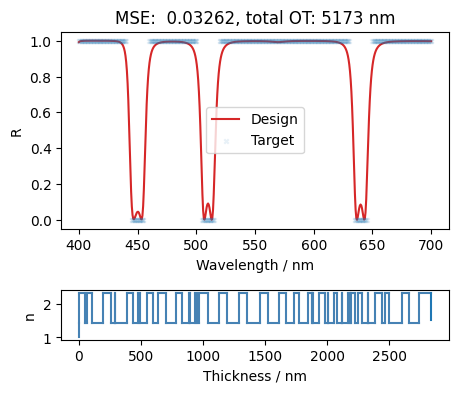

In [289]:
def plot(film, specs, fname):
    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': (4, 1), 'hspace': 0.5})
    # fig.set_size_inches(5, 10)

    film_spec = film.get_spec(inc_ang=0, wls=np.linspace(400, 700, 500))
    ax = axes[0]
    ax.plot(film_spec.WLS, film_spec.get_R(), label='Design', zorder=1, color='C3')
    ax.scatter(specs[0].WLS, specs[0].get_R(), label='Target', marker='x', s=10, zorder=2, alpha=0.1)

    ax.set_title(f'MSE: {calculate_RMS_f_spec(film, specs): .5f}, total OT: {film.get_optical_thickness(1000):.0f} nm') #, final layer number: {film.get_layer_number()}')
    # print(film.get_layer_number())
    # film.remove_negative_thickness_layer(zero=10)
    # print(film.get_layer_number())
    # ax.plot(film.get_spec().WLS, film.get_spec().get_R(), label='After removal')

    ax.legend()
    ax.set_xlabel('Wavelength / nm')
    ax.set_ylabel('R')
    fig.set_size_inches(5, 3)

    plot_layer_thickness(film, ax=axes[1])
    axes[1].set_ylabel('n')
    axes[1].set_xlabel('Thickness / nm')

    fig.set_size_inches(5, 4)
    fig.savefig(f'./images/threeline_filter/{fname}.pdf', bbox_inches='tight')

film.remove_negative_thickness_layer()
plot(film, target, fname='threeline_filter_start_100layers_50nm')
print(film.get_optical_thickness(1000))